# Evaluation of RAG architectures

In [ ]:
from tqdm import tqdm
from pathlib import Path
from llms.clients.gpt import GPTClient
from llms.settings import settings
from llms.rag.faiss import DistanceMetric
from llms.evaluation.code import evaluate_code_generation, ConfigGrid, RAG, RAGRetriever
from tests.pandas import TEST_CASES

In [ ]:
def get_texts(folder_paths: list[str]) -> list[str]:
    folder_paths = [Path(folder_path) for folder_path in folder_paths]
    files = []
    for folder_path in tqdm(folder_paths, desc="Searching for files"):
        for child in folder_path.iterdir():
            if child.is_file():
                files.append(child)
    texts = []
    for file in tqdm(files, desc="Reading files"):
        with open(file, "r", encoding="utf-8") as f:
            content = f.read()
            texts.append(content)
    return texts

In [ ]:
folder_paths = ["files/pandas/textfiles/textfiles1", "files/pandas/textfiles/textfiles2", "files/pandas/textfiles/textfiles3"]
texts = get_texts(folder_paths)

In [ ]:
gpt_4_client = GPTClient(
    client_id=settings.CLIENT_ID,
    client_secret=settings.CLIENT_SECRET,
    auth_url=settings.AUTH_URL,
    api_base=settings.API_BASE,
    deployment_id='gpt-4-32k',
    max_response_tokens=1000,
    temperature=0.0,
)

In [ ]:
config_grid = ConfigGrid(
    llms=[gpt_4_client],
    rag=RAG(
        retrievers=[
            RAGRetriever.NONE,
            RAGRetriever.RAG,
            RAGRetriever.RAG_AS_TOOL,
            RAGRetriever.CoALA,
            RAGRetriever.CoALA_AS_TOOL,
        ],
        distance_metrics=[DistanceMetric.EUCLIDEAN_DISTANCE, DistanceMetric.MAX_INNER_PRODUCT],
        num_search_results=[3],
        similarity_search_score_thresholds=[0.0],
        text_chunk_sizes=[512],
        use_weighted_average_of_text_chunks=[True],
        texts=texts,
    )
)

In [ ]:
results = evaluate_code_generation(config_grid=config_grid, test_cases=TEST_CASES, test_name="pandas_test")

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

c:\Users\marcg\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path = "./results"
df = pd.read_csv(f"{path}/pandas_results.csv")

In [15]:
df = df.reset_index()
display(df)

,level_0,index,config,accuracy,total_time,total_cost,details_csv_filepath
0,0,0,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.40,545.893470,20.423264,results/details/gpt-4-32k_RAGRetriever.RAG_Dis...
1,1,1,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.40,447.659310,21.386189,results/details/gpt-4-32k_RAGRetriever.CoALA_D...
2,2,2,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.35,348.562941,19.623164,results/details/gpt-4-32k_RAGRetriever.RAG_Dis...
3,3,3,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.35,430.342784,20.791775,results/details/gpt-4-32k_RAGRetriever.CoALA_D...
4,4,4,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.30,674.764801,22.992972,results/details/gpt-4-32k_RAGRetriever.CoALA_A...
5,5,5,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.25,223.853544,1.719149,results/details/gpt-4-32k_RAGRetriever.NONE_No...
6,6,6,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.25,424.385958,6.994267,results/details/gpt-4-32k_RAGRetriever.RAG_AS_...
7,7,7,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.25,438.385903,7.700234,results/details/gpt-4-32k_RAGRetriever.CoALA_A...
8,8,8,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.25,799.720272,18.199901,results/details/gpt-4-32k_RAGRetriever.RAG_AS_...


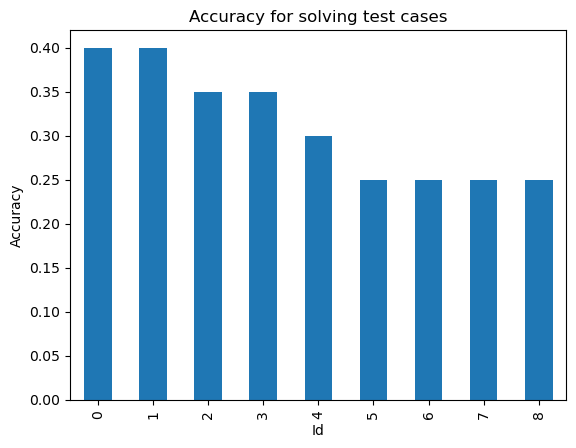

In [4]:
df.plot(kind='bar', x='index', y='accuracy', legend=False)
plt.title('Accuracy for solving test cases')
plt.xlabel('Id')
plt.ylabel('Accuracy')
plt.show()

In [14]:
fig = px.bar(df, x='index', y='accuracy', title='Accuracy for solving test cases',
             labels={'index': 'Id', 'accuracy': 'Accuracy'}, width=800, height=500)

fig.update_layout(xaxis_title='Configuration', yaxis_title='Accuracy', showlegend=False, bargap=0.2,
                    xaxis=dict(tickmode='linear', tick0=0, dtick=1),
                    yaxis=dict(tickfont=dict(size=25)),
                    yaxis_title_font=dict(size=25),
                    xaxis_title_font=dict(size=25),
                    title_font=dict(size=30))

fig.show()
fig.write_image("total_acc.png", width=1200, height=800, scale=2)  # Adjust width, height, and scale as needed

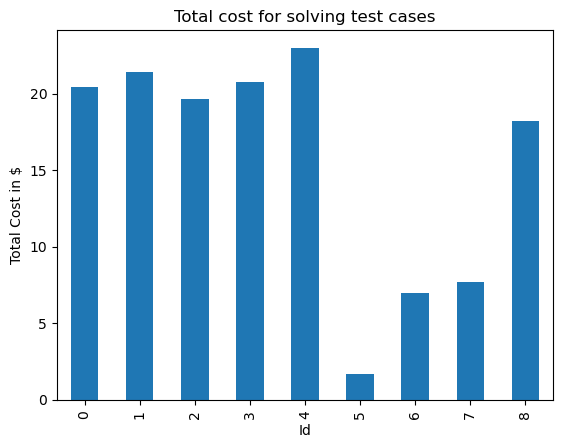

In [16]:
df.plot(kind='bar', x='index', y='total_cost', legend=False)
plt.title('Total cost for solving test cases')
plt.xlabel('Id')
plt.ylabel('Total Cost in $')
plt.show()

In [18]:
fig = px.bar(df, x='index', y='total_cost', title='Total Cost for Configuration (20 TC)',
             labels={'index': 'Id', 'total_cost': 'Total Cost'}, width=800, height=500)

fig.update_layout(xaxis_title='Configuration', yaxis_title='Total Cost', showlegend=False, bargap=0.2,
                    xaxis=dict(tickmode='linear', tick0=0, dtick=1),
                    yaxis=dict(tickfont=dict(size=25)),
                    yaxis_title_font=dict(size=25),
                    xaxis_title_font=dict(size=25),
                    title_font=dict(size=30))

fig.show()
fig.write_image("total_cost.png", width=1200, height=800, scale=2)  # Adjust width, height, and scale as needed

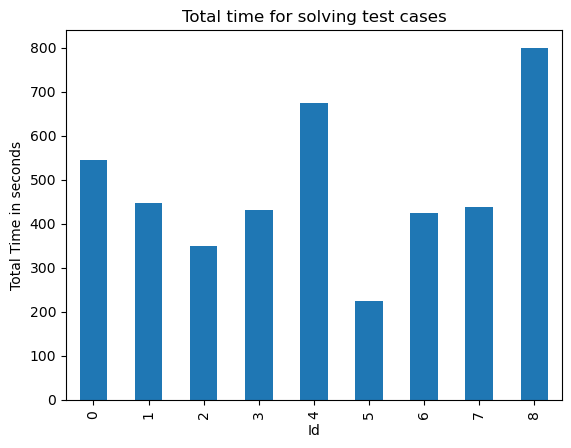

In [19]:
df.plot(kind='bar', x='index', y='total_time', legend=False)
plt.title('Total time for solving test cases')
plt.xlabel('Id')
plt.ylabel('Total Time in seconds')
plt.show()

In [26]:
fig = px.bar(df, x='index', y='total_time', title='Total Time taken for 20 Test Cases',
             labels={'index': 'Id', 'total_time': 'Total Time'}, width=800, height=500)

fig.update_layout(xaxis_title='Configuration', yaxis_title='Total Time taken (seconds)', showlegend=False, bargap=0.2,
                    xaxis=dict(tickmode='linear', tick0=0, dtick=1),
                    yaxis=dict(tickfont=dict(size=20)),
                    yaxis_title_font=dict(size=25),
                    xaxis_title_font=dict(size=25),
                    title_font=dict(size=30))

fig.show()
fig.write_image("total_time.png", width=1200, height=800, scale=2)  # Adjust width, height, and scale as needed

In [ ]:
details_path = df.iloc[0].details_csv_filepath
details_df = pd.read_csv(details_path)
details_df